In [1]:
import tensorflow as tf
# List all physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for:", physical_devices[0])
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print("Error setting memory growth:", e)
else:
    print("No GPU devices found.")

Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
with tf.device('/cpu:0'):
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    import matplotlib.pyplot as plt

In [3]:
with tf.device('/cpu:0'):

    X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_train_CI3.npz')
    X_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_test_CI3.npz')
    Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_train_CI3.npz')
    Y_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_test_CI3.npz')
    
    X_train =X_train['X']
    X_test  =X_test ['X']
    
    Y_train =Y_train['X']
    Y_test  =Y_test ['X']

In [4]:
def build_vanilla_autoencoder(input_shape, hidden_layers):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Flatten()(input_layer)
    for neurons in hidden_layers:
        x = Dense(neurons, activation="relu")(x)
    encoded = x

    # Decoder
    for neurons in reversed(hidden_layers):
        x = Dense(neurons, activation="relu")(x)
    x = Dense(np.prod(input_shape), activation="sigmoid")(x)
    decoded = Reshape(input_shape)(x)

    # Autoencoder
    autoencoder = Model(input_layer, decoded)
    # Encoder model
    encoder = Model(input_layer, encoded)
    #decoder model
    decoder = Model(encoded, decoded)

    return autoencoder, encoder, decoder

In [6]:
hidden_layer_configs = [
    [256, 128],
] # best config from cross validation

input_shape = X_train.shape[1:]
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')
# Build and compile the autoencoder
autoencoder, encoder, decoder = build_vanilla_autoencoder(input_shape, hidden_layer_configs[0])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse",metrics =["accuracy"])
# Train the autoencoder
history = autoencoder.fit(X_train, X_train,
                           epochs=10,
                           batch_size=32,
                           validation_split=0.2,
                           callbacks=[early_stop],
                           verbose = 1)

Epoch 1/10
215/215 [==============================] - 6s 24ms/step - loss: 0.7273 - accuracy: 0.4875 - val_loss: 0.6668 - val_accuracy: 0.5986
Epoch 2/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6528 - accuracy: 0.6024 - val_loss: 0.6468 - val_accuracy: 0.6109
Epoch 3/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6361 - accuracy: 0.6255 - val_loss: 0.6364 - val_accuracy: 0.6295
Epoch 4/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6270 - accuracy: 0.6382 - val_loss: 0.6300 - val_accuracy: 0.6508
Epoch 5/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6207 - accuracy: 0.6476 - val_loss: 0.6263 - val_accuracy: 0.6588
Epoch 6/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6163 - accuracy: 0.6531 - val_loss: 0.6236 - val_accuracy: 0.6392
Epoch 7/10
215/215 [==============================] - 5s 23ms/step - loss: 0.6128 - accuracy: 0.6579 - val_loss: 0.6219 - val_accuracy: 0.6555

In [7]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               3145984   
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 12288)             3158

In [9]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# visualizing the results
def visualize_results(y_test,y_predict):
    #class_names = [folder for folder in os.listdir(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories") if os.path.isdir(os.path.join(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories", folder))]
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate accuracy for each class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Display class-wise accuracy
    #classes = [f"Class {i}" for i in range(len(class_accuracies))]  # Replace with actual class names if available
    array = np.arange(0, 100)
    # Plot the accuracies
    plt.figure(figsize=(15, 5))
    plt.bar(array, class_accuracies, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-Wise Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 100)  # Accuracy is in percentage
    plt.tight_layout()
    plt.show()

48/48 [==============================] - 0s 7ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4768438468113618..2.6511234699621005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.938978518926209..2.5493185456580836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8242409329755822..2.243903772746033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8242409329755822..2.76989588165012].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.938978518926209..1.7182820332500215].


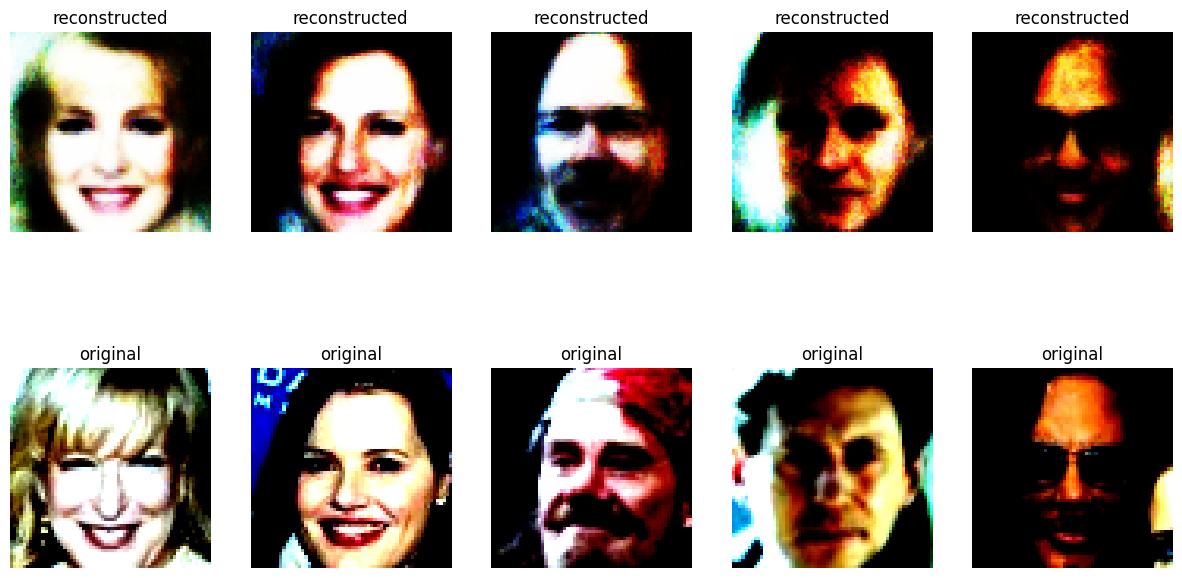

In [10]:

SS = autoencoder.predict(X_test)

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2, 5, 1+i)

    plt.imshow(SS[200+i])
    plt.axis('off')
    plt.title(f"reconstructed")


    plt.subplot(2, 5, i+6)
    plt.imshow(X_test[200+i])
    plt.axis('off')
    plt.title(f"original")

plt.show()


269/269 [==============================] - 2s 8ms/step


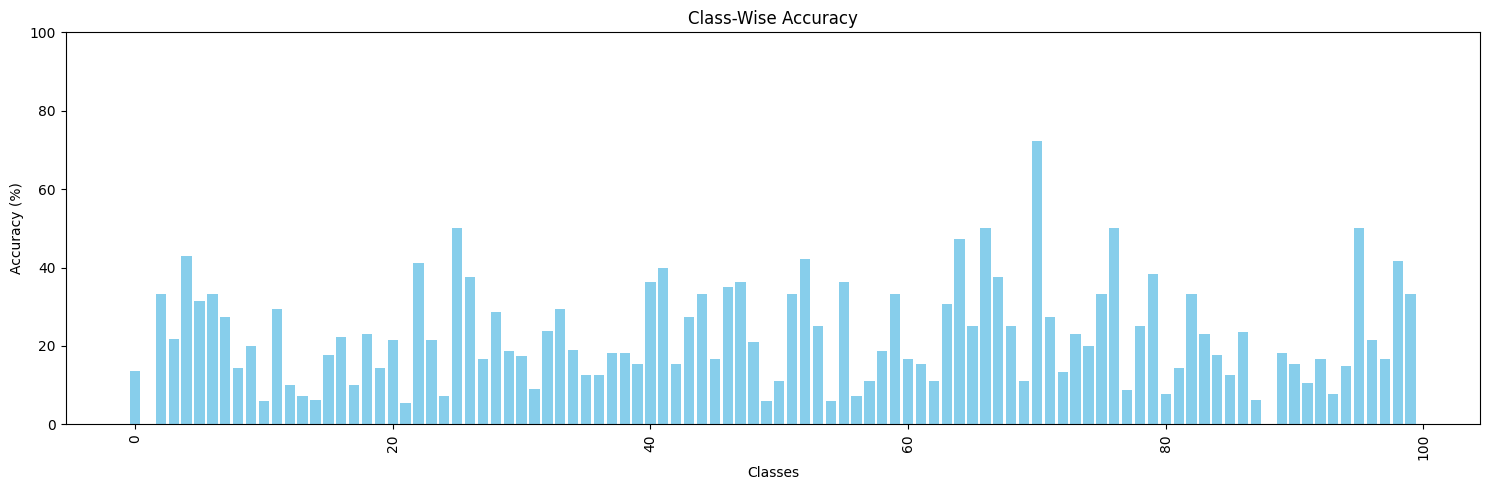

In [12]:
#ecludian distance classifer "NN"
with tf.device('/cpu:0'):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import confusion_matrix
    
    
    feature_vector_test = encoder.predict(X_test)
    feature_vector_train =encoder.predict(X_train)
    
    
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(feature_vector_train, Y_train)
    predictions = knn.predict(feature_vector_test)
    accuracy(Y_test, predictions)
    visualize_results(Y_test,predictions)


In [13]:
accuracy(Y_test, predictions)

22.970297029702973